# Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from collections import deque
import datetime as dt
import mplfinance 
from renkodf import Renko
from scipy.signal import lfilter
import fx # personal functions
import fx_rl
from datetime import datetime, timedelta
# import MetaTrader5 as mt5

# Gathering Data

In [2]:
df_crossvalidation_5min = (
    pl.scan_csv('crossvalidation_df_LR_5min.csv')
    .select([
        pl.col('cutoff').alias('ds'),
        # pl.col('ds'),
        pl.col('LinearRegression').alias('pred') #.round(5)
    ])
).collect()
len(df_crossvalidation_5min)

480952

In [3]:
df_w_news = (
    pl.scan_csv(f'EURUSD_full_tickstory_data_15_min_ready.csv')
    # convert 'Time' to datetime
    .with_columns([
        # add a unique_id col which will be 'EURUSD' as a string
        pl.lit('EURUSD').alias('unique_id').cast(pl.Utf8),
        pl.col('Time').alias('Datetime').str.to_datetime(format='%Y-%m-%d %H:%M:%S'),#T %.f
        pl.arange(0, pl.len()).alias('ds'),
        # .dt.replace_time_zone('UTC'),
        # add a column that takes the sum of 'Open' 'High' 'Low' and 'Close' and divides it by 4
        pl.col('Close').alias('y')
    ])
    # .filter(pl.col('ds') >= pl.date(2023, 1, 1))
    # sort by 'Date'
   .sort('ds')
   .select(pl.col('unique_id', 'ds', 'y', 'seconds_since_last_news_event', 'seconds_to_next_news_event', 'Datetime'))
    )

# Load the second CSV file and rename columns
df_crossvalidation = (
    pl.scan_csv('crossvalidation_df_RWD.csv')
    .select([
        pl.col('cutoff').alias('ds'),
        # pl.col('ds'),
        pl.col('RWD').alias('pred') #.round(5)
    ])
)

# Join the DataFrames on the 'ds' column
df_joined = df_w_news.join(df_crossvalidation, on='ds', how='inner').rename(lambda col_name: col_name.lower()).collect()

df_joined

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,datetime,pred
str,i64,f64,i64,i64,datetime[μs],f64
"""EURUSD""",40004,1.23977,-63900,32400,2018-03-08 10:45:00,1.2397732
"""EURUSD""",40005,1.23897,-64800,31500,2018-03-08 11:00:00,1.2389731
"""EURUSD""",40006,1.23891,-65700,30600,2018-03-08 11:15:00,1.238913
"""EURUSD""",40007,1.23863,-66600,29700,2018-03-08 11:30:00,1.238633
"""EURUSD""",40008,1.23828,-67500,28800,2018-03-08 11:45:00,1.238283
…,…,…,…,…,…,…
"""EURUSD""",200331,1.09185,-297000,147600,2024-08-09 22:30:00,1.0918499
"""EURUSD""",200332,1.09185,-297900,146700,2024-08-09 22:45:00,1.0918499
"""EURUSD""",200333,1.09179,-298800,145800,2024-08-09 23:00:00,1.0917898


In [4]:

# df_processed = fcst.preprocess(df_joined, static_features=[])
max_date_1hr = df_joined.select(pl.col('datetime').max()).item()
testing = True
if testing:
    train, validation, test = fx_rl.slices_finder_polars(df_joined, max_date_1hr, date_col='datetime', testing_needed=testing)
    train = train.select(*df_joined.columns).drop("datetime")
    validation = validation.drop("datetime")
    test = test.drop("datetime")
else:
    train, validation = fx_rl.slices_finder_polars(df_joined, max_date_1hr, date_col='datetime', testing_needed=testing)
    train = train.select(*df_joined.columns).drop("datetime")
    validation = validation.drop("datetime")
train

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,pred
str,i64,f64,i64,i64,f64
"""EURUSD""",40004,1.23977,-63900,32400,1.2397732
"""EURUSD""",40005,1.23897,-64800,31500,1.2389731
"""EURUSD""",40006,1.23891,-65700,30600,1.238913
"""EURUSD""",40007,1.23863,-66600,29700,1.238633
"""EURUSD""",40008,1.23828,-67500,28800,1.238283
…,…,…,…,…,…
"""EURUSD""",199371,1.08576,-25200,135000,1.0857599
"""EURUSD""",199372,1.08572,-26100,134100,1.0857198
"""EURUSD""",199373,1.08569,-27000,133200,1.0856899


## Parameters

In [5]:
# Renko variable
# brick_size = 0.00081
# # multiply brick_size by 10,000 to get a whole number
# brick_size_str = str(int(brick_size*100000))

# Lot Size
lot_size = 1
per_lot = 100_000

# pyramid
pyramid_size = 4
pyramid_bool = True

# stop loss
stop_loss_size = 0.00033*4
# threshold for entry
threshold = 0.00033*3

# take profit
take_profit_size = 0.00033*5

# Commissions
nova_commission = lot_size * -3
msolutions_commission = lot_size * -5

# starting balance
balance = 200000

# base currency rate
base_currency_rate = 0.045 # EUR
quote_currency_rate = 0.055 # USD

## Entry conditions

In [6]:
# create a string of 80 '#' characters
hashes = '#' * 80
# print the hashes string
print(hashes)

################################################################################


In [7]:
pl.scan_csv('EURUSD_full_tickstory_data_hourly.csv').collect_schema().names()

['Time', 'Open', 'High', 'Low', 'Close']

In [8]:
# create a column called Pred_lag1 which is the lag of the Pred column in polars
df_joined_lag3 = df_joined.with_columns(
    # pl.col("Pred").shift(-1).alias("Pred_lag1"),
    pl.col("pred").shift(-3).alias("pred_lag3"),
).drop_nulls(subset=["pred_lag3"])

full_ohlc_hourly_df = (
    pl.scan_csv('EURUSD_full_tickstory_data_hourly.csv')# 15_min
    .with_columns([
        # pl.col('cutoff').alias('ds'),
        pl.col('Time').alias('datetime').str.to_datetime(format='%Y-%m-%d %H:%M:%S+00:00'),
    ])
    .drop('Time')
).rename(lambda col_name: col_name.lower()).collect()

df_joined_hourly = df_joined_lag3.join(full_ohlc_hourly_df, on='datetime', how='inner')   

# create the buy and sell signals which is that if the Pred_lag1 is greater than the y by threshold then buy and if the Pred_lag1 is less than the y by threshold then sell
df_joined_bs = df_joined_hourly.with_columns(
    (pl.col("pred_lag3") > pl.col("y") + threshold).cast(pl.Int8).alias("buy"),
    (pl.col("pred_lag3") < pl.col("y") - threshold).cast(pl.Int8).alias("sell"),
    # (pl.col('y') - pl.col('Pred_lag1')).alias("y_diff")
)

# create a column called signal which is the buy column if the buy column is 1 and the sell column is 0 and the sell column * -1 if the buy column is 0 and the sell column is 1 and 0 if the buy column is 0 and the sell column is 0
df_joined_signal = df_joined_bs.with_columns(
    (pl.col("buy") + (pl.col("sell") * -1)).alias("signal"),
)
df_joined_signal

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,datetime,pred,pred_lag3,open,high,low,close,buy,sell,signal
str,i64,f64,i64,i64,datetime[μs],f64,f64,f64,f64,f64,f64,i8,i8,i8
"""EURUSD""",40005,1.23897,-64800,31500,2018-03-08 11:00:00,1.2389731,1.238283,1.23925,1.23942,1.2378,1.23826,0,0,0
"""EURUSD""",40009,1.23834,-68400,27900,2018-03-08 12:00:00,1.238343,1.238013,1.23825,1.23897,1.23776,1.23786,0,0,0
"""EURUSD""",40013,1.23758,-72000,24300,2018-03-08 13:00:00,1.2375829,1.237423,1.23786,1.2379,1.23687,1.23782,0,0,0
"""EURUSD""",40017,1.23818,-75600,20700,2018-03-08 14:00:00,1.238183,1.2398831,1.23783,1.24312,1.23729,1.241,1,0,1
"""EURUSD""",40021,1.24164,-79200,17100,2018-03-08 15:00:00,1.2416431,1.2406931,1.241,1.2446,1.23844,1.24027,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""EURUSD""",200313,1.09237,-280800,163800,2024-08-09 18:00:00,1.0923699,1.0924898,1.09231,1.09276,1.09216,1.09241,0,0,0
"""EURUSD""",200317,1.09211,-284400,160200,2024-08-09 19:00:00,1.0921099,1.0919299,1.0924,1.09245,1.09178,1.09186,0,0,0
"""EURUSD""",200321,1.09174,-288000,156600,2024-08-09 20:00:00,1.0917399,1.0921599,1.09186,1.09234,1.09151,1.09206,0,0,0


In [9]:
# get the date without the time from 'Datetime' from df_joined_signal which is a polars dataframe
daily = df_joined_signal.select(pl.col('datetime').dt.date()).unique()
daily.count()

datetime
u32
1674


In [10]:
# find the sum of signal
df_joined_signal.sum()
# 18 signals per day

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,datetime,pred,pred_lag3,open,high,low,close,buy,sell,signal
str,i64,f64,i64,i64,datetime[μs],f64,f64,f64,f64,f64,f64,i64,i64,i64
null,4816631373,44876.03482,-2905001100,3036367500,null,44876.04123,44876.140423,44875.85309,44903.37339,44848.57491,44875.70678,2772,2828,-56


In [11]:
# adjust signal to have the word 'buy' if it is 1 and 'sell' if it is -1 and "" if it is 0 for df_joined_signal which is a polars dataframe
df_joined_signal_txt = df_joined_signal.with_columns(
    pl.when(pl.col('signal') == 1)
    .then(pl.lit('buy'))
    .when(pl.col('signal') == -1)
    .then(pl.lit('sell'))
    .otherwise(pl.lit(None))
    .alias('signal_text'),
    # add a column for the day of the week 
    pl.col('datetime').dt.weekday().alias('day_of_week'),
    pl.col('datetime').dt.week().alias('week_of_year'),
)
# add a column to indicate a transition between weeks by placing a 1 in the column if the week of year changes in the next row
df_joined_week_trans = df_joined_signal_txt.with_columns(
    pl.when((pl.col('week_of_year') != pl.col('week_of_year').shift(-1)) |
    (pl.col('week_of_year') != pl.col('week_of_year').shift(1)) |
    (pl.col('week_of_year') != pl.col('week_of_year').shift(2)) |
    (pl.col('week_of_year') != pl.col('week_of_year').shift(3)))
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias('week_transition')
)
# df_joined_week_trans

In [12]:
# if the week_transition is 1 and signal is not 0 then replace signal_text with 'exit' for the df_joined_week_trans polars dataframe
df_joined_week_trans_exit = df_joined_week_trans.with_columns(
    pl.when(
        (pl.col("week_transition") == 1) & (pl.col("signal") != 0)
    )
    .then(pl.lit("exit"))
    .otherwise(pl.col("signal_text")).alias("signal_text")
)

In [13]:
# filter to those rows where the signal_text is not null, exit
positions = df_joined_week_trans_exit.filter(
    (pl.col('signal_text').is_not_null()) & 
    (pl.col('signal_text') != 'exit') & 
    ((abs(pl.col('seconds_since_last_news_event')) > 900) &
     (abs(pl.col('seconds_to_next_news_event')) > 900)) &
    ((pl.col('signal_text').shift().is_null()) | (pl.col('signal_text').shift() != pl.col('signal_text')))
    ).with_columns(
    pl.when(pl.col('signal_text') == 'buy')
    .then(pl.col('close') + take_profit_size)
    .when(pl.col('signal_text') == 'sell')
    .then(pl.col('close') - take_profit_size)
    .otherwise(None)
    .alias('take_profit'),
    pl.when(pl.col('signal_text') == 'buy')
    .then(pl.col('close') - stop_loss_size)
    .when(pl.col('signal_text') == 'sell')
    .then(pl.col('close') + stop_loss_size)
    .otherwise(None)
    .alias('stop_loss')
    ).select(
        pl.col('signal_text').alias('direction'),
        pl.col('datetime').alias('entry_time'),
        pl.col('close').alias('entry_price'),
        pl.col('take_profit'),
        pl.col('stop_loss'),
    )
# for each position in the positions polars dataframe, determine the exit price based on take_profit and stop_loss


In [14]:
positions.columns

['direction', 'entry_time', 'entry_price', 'take_profit', 'stop_loss']

In [15]:
import polars as pl
from datetime import time

def find_exit_price(row, full_data=df_joined_week_trans_exit) -> pl.List:
    position_type, entry_time, stop_loss_price, take_profit_price = row
    entry_time = pd.to_datetime(entry_time)

    # Filter the full_data to only include rows where 'datetime' is > entry_time
    filtered_df = full_data.filter(pl.col('datetime') > entry_time)

    # Check all exit conditions
    result = filtered_df.select([
        pl.col('datetime'),
        pl.col('high'),
        pl.col('low'),
        pl.col('open'),
        pl.col('close'),
        pl.col('week_transition'),
        (pl.col('high') >= take_profit_price).alias('take_profit_hit'),
        (pl.col('low') <= stop_loss_price).alias('stop_loss_hit'),
        (pl.col('week_transition') == 1).alias('week_transition_hit'),
        ((pl.col('datetime').dt.time() == time(0,0,0)) & 
         (pl.lit(position_type) == 'buy')).alias('swap_hit')
    ]).filter(
        pl.col('take_profit_hit') | pl.col('stop_loss_hit') | pl.col('week_transition_hit') | pl.col('swap_hit')
    ).sort('datetime').head(1)

    if len(result) == 0:
        return [None, None]

    exit_row = result.row(0)
    # print(exit_row)
    exit_time = exit_row[0]

    if exit_row[-4]: # take_profit_hit
        exit_price = take_profit_price
    elif exit_row[-3]: # stop_loss_hit
        exit_price = stop_loss_price
    elif exit_row[-2]: # week_transition_hit
        exit_price = exit_row[4] # close price
    elif exit_row[-1]: # swap_hit
        exit_price = exit_row[3] # open price
    else:
        return [None, None]

    return [exit_time, exit_price]
find_exit_price([positions.row(0)[0], positions.row(0)[1], positions.row(0)[4], positions.row(0)[3]])

[datetime.datetime(2018, 3, 8, 15, 0), 1.2396800000000001]

In [16]:
exit_times = []
exit_prices = []
for row in positions.iter_rows():
    exit_time, exit_price = find_exit_price([row[0], row[1], row[4], row[3]])
    exit_times.append(exit_time)
    exit_prices.append(exit_price)
    
positions_with_exit_info = positions.with_columns([
    pl.Series("exit_time", exit_times),
    pl.Series("exit_price", exit_prices)
])

In [17]:
holding_lengths = positions_with_exit_info.with_columns([
    (pl.col("exit_time") - pl.col('entry_time')).alias('holding_time'),
])['holding_time'].value_counts()
holding_lengths

holding_time,count
duration[μs],u32
4h,150
13h,3
14h,2
7h,60
9h,10
…,…
10h,3
5h,118
11h,2


In [18]:
positions_with_exit_info

direction,entry_time,entry_price,take_profit,stop_loss,exit_time,exit_price
str,datetime[μs],f64,f64,f64,datetime[μs],f64
"""buy""",2018-03-08 14:00:00,1.241,1.24265,1.23968,2018-03-08 15:00:00,1.23968
"""sell""",2018-03-08 16:00:00,1.23508,1.23343,1.2364,2018-03-08 17:00:00,1.2364
"""sell""",2018-03-09 10:00:00,1.2306,1.22895,1.23192,2018-03-09 11:00:00,1.23192
"""buy""",2018-03-09 16:00:00,1.23121,1.23286,1.22989,2018-03-09 17:00:00,1.23286
"""buy""",2018-03-12 10:00:00,1.23375,1.2354,1.23243,2018-03-12 11:00:00,1.23243
…,…,…,…,…,…,…
"""sell""",2024-08-05 18:00:00,1.09561,1.09396,1.09693,2024-08-05 19:00:00,1.09693
"""buy""",2024-08-06 03:00:00,1.09627,1.09792,1.09495,2024-08-06 08:00:00,1.09495
"""sell""",2024-08-07 04:00:00,1.09181,1.09016,1.09313,2024-08-07 05:00:00,1.09313


## Specific Day

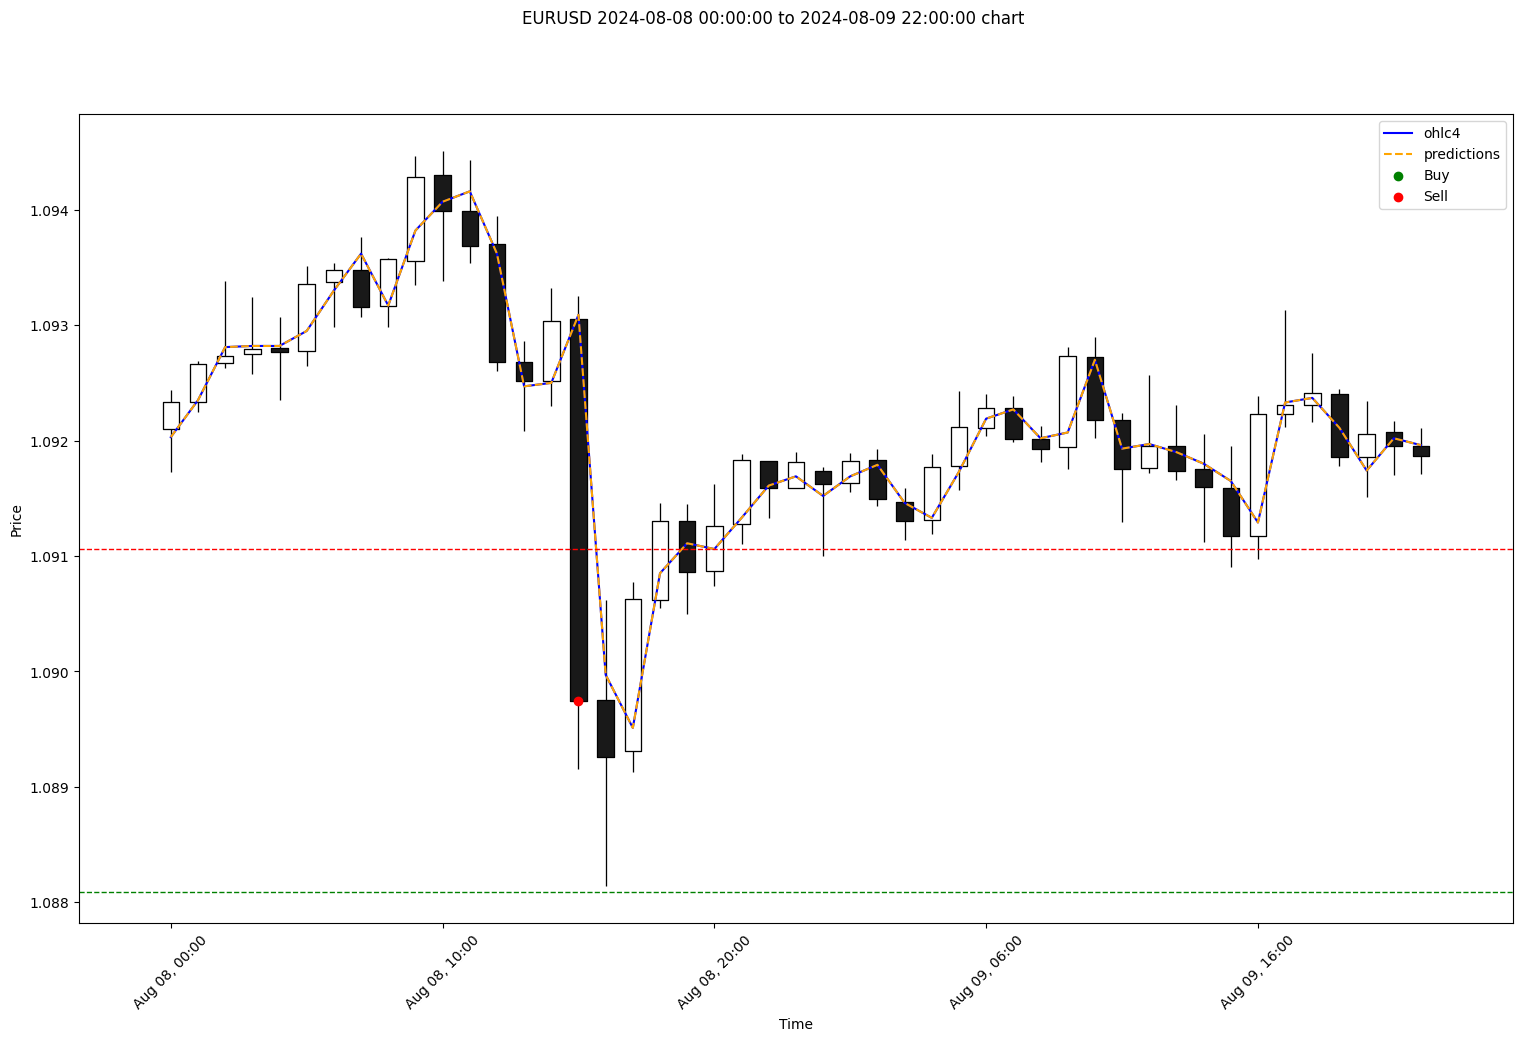

In [19]:
df_select_day = df_joined_week_trans_exit.join(
    positions_with_exit_info, left_on='datetime', right_on='entry_time', how='left'
).filter(
    pl.col('datetime').dt.date() >= (pl.col('datetime').dt.date().max() - timedelta(days=1))
).to_pandas().set_index('datetime')

# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(df_select_day, type='candle', ax=ax, volume=False, show_nontrading=False)
df_select_day_reset = df_select_day.reset_index()
# add the sma and smoothing_sma to the chart
ax.plot(df_select_day_reset.index, df_select_day['y'], label='ohlc4', color='blue')
ax.plot(df_select_day_reset.index, df_select_day['pred'], label='predictions', linestyle='--', color='orange')
# add a column to df_select_day_reset that copies the close price when sma_crossover is 1 or -1
df_select_day_reset['price_buy'] = np.where((~df_select_day['entry_price'].isnull()) & (df_select_day['signal'] == 1), df_select_day['close'], np.nan)
df_select_day_reset['price_sell'] = np.where((~df_select_day['entry_price'].isnull()) & (df_select_day['signal'] == -1), df_select_day['close'], np.nan)

tps = df_select_day[~df_select_day['entry_price'].isnull()]['take_profit']
sls = df_select_day[~df_select_day['entry_price'].isnull()]['stop_loss']

# add a dot to the chart with the sma_crossover is 1 or -1 and color it green or red
ax.scatter(df_select_day_reset.index, df_select_day_reset['price_buy'], color='green', marker='o', label='Buy', zorder=5)
ax.scatter(df_select_day_reset.index, df_select_day_reset['price_sell'], color='red', marker='o', label='Sell', zorder=5)

for tp, sl in zip(tps, sls):
    ax.axhline(y=tp, color='green', linestyle='--', linewidth=1)
    ax.axhline(y=sl, color='red', linestyle='--', linewidth=1)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# find the date of the first and last index
first_date = df_select_day_reset['datetime'].iloc[0]
last_date = df_select_day_reset['datetime'].iloc[-1]
fig.suptitle(f'EURUSD {first_date} to {last_date} chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [20]:
# profit calculations
profit_df = positions_with_exit_info.with_columns(
    pl.when(pl.col('direction') == 'buy')
    .then(
        (((pl.col("exit_price") - pl.lit(max(0., np.random.normal(0.0001, 0.00003)))) - 
        (pl.col("entry_price") + pl.lit(max(0., np.random.normal(0.0001, 0.00003))))) * per_lot * lot_size) + msolutions_commission
    )
    .otherwise(
        (((pl.col("entry_price") - pl.lit(max(0., np.random.normal(0.0001, 0.00003)))) -
        (pl.col("exit_price") + pl.lit(max(0., np.random.normal(0.0001, 0.00003)))))  * per_lot * lot_size) + msolutions_commission
        ).alias("profit")
)

## Pyramiding
Already happening within the logic. 

### check for weekend holds

In [21]:
weekend_holdings = profit_df.filter(pl.col('entry_time').dt.week() != pl.col('exit_time').dt.week())
if len(weekend_holdings) > 0:
    ValueError("There is a trade that is holding over the weekend")
    weekend_holdings

In [22]:
profit_df

direction,entry_time,entry_price,take_profit,stop_loss,exit_time,exit_price,profit
str,datetime[μs],f64,f64,f64,datetime[μs],f64,f64
"""buy""",2018-03-08 14:00:00,1.241,1.24265,1.23968,2018-03-08 15:00:00,1.23968,-162.02597
"""sell""",2018-03-08 16:00:00,1.23508,1.23343,1.2364,2018-03-08 17:00:00,1.2364,-154.807385
"""sell""",2018-03-09 10:00:00,1.2306,1.22895,1.23192,2018-03-09 11:00:00,1.23192,-154.807385
"""buy""",2018-03-09 16:00:00,1.23121,1.23286,1.22989,2018-03-09 17:00:00,1.23286,134.97403
"""buy""",2018-03-12 10:00:00,1.23375,1.2354,1.23243,2018-03-12 11:00:00,1.23243,-162.02597
…,…,…,…,…,…,…,…
"""sell""",2024-08-05 18:00:00,1.09561,1.09396,1.09693,2024-08-05 19:00:00,1.09693,-154.807385
"""buy""",2024-08-06 03:00:00,1.09627,1.09792,1.09495,2024-08-06 08:00:00,1.09495,-162.02597
"""sell""",2024-08-07 04:00:00,1.09181,1.09016,1.09313,2024-08-07 05:00:00,1.09313,-154.807385


## Max Daily Drawdown

In [23]:
import polars as pl

# Convert entry_time to datetime
profit_df = profit_df.with_columns(pl.col('entry_time').cast(pl.Datetime))

# Group by day and sum the profit
profit_df_daily = profit_df.group_by_dynamic('entry_time', every='1d').agg(
    pl.col('profit').sum().alias('profit')
)

# Add day of week column
profit_df_daily_weekdays = profit_df_daily.with_columns(
    pl.col('entry_time').dt.weekday().alias('day_of_week')
)

# Find the minimum profit
min_profit = profit_df_daily_weekdays['profit'].min()

# Find the days when profit equals min
min_profit_days = profit_df_daily_weekdays.filter(pl.col('profit') == min_profit)

# Display results
min_profit_days


entry_time,profit,day_of_week
datetime[μs],f64,i8
2020-03-09 00:00:00,-1731.755573,1


# End Values (Total Profit, Days in Drawdown)

In [24]:
# filter profit_df_daily to only have where the profit is < 0
profit_df_daily_drawdown = profit_df_daily.filter(pl.col('profit') < 0)

print(f'total days in drawdown: {len(profit_df_daily_drawdown)} \
      \ntotal days: {len(profit_df_daily)}\
      \npercentage of days in drawdown: {len(profit_df_daily_drawdown)/len(profit_df_daily)}\
      \ntotal profit: ${profit_df["profit"].sum():,.2f}')

total days in drawdown: 1292       
total days: 1452      
percentage of days in drawdown: 0.8898071625344353      
total profit: $-408,105.53


## Previous year

In [25]:

prev_year_profit_df = profit_df.filter(pl.col('entry_time') >= (max_date_1hr - timedelta(days=365)))
print(f'total profit: ${prev_year_profit_df["profit"].sum():,.2f}')

total profit: $-42,909.49


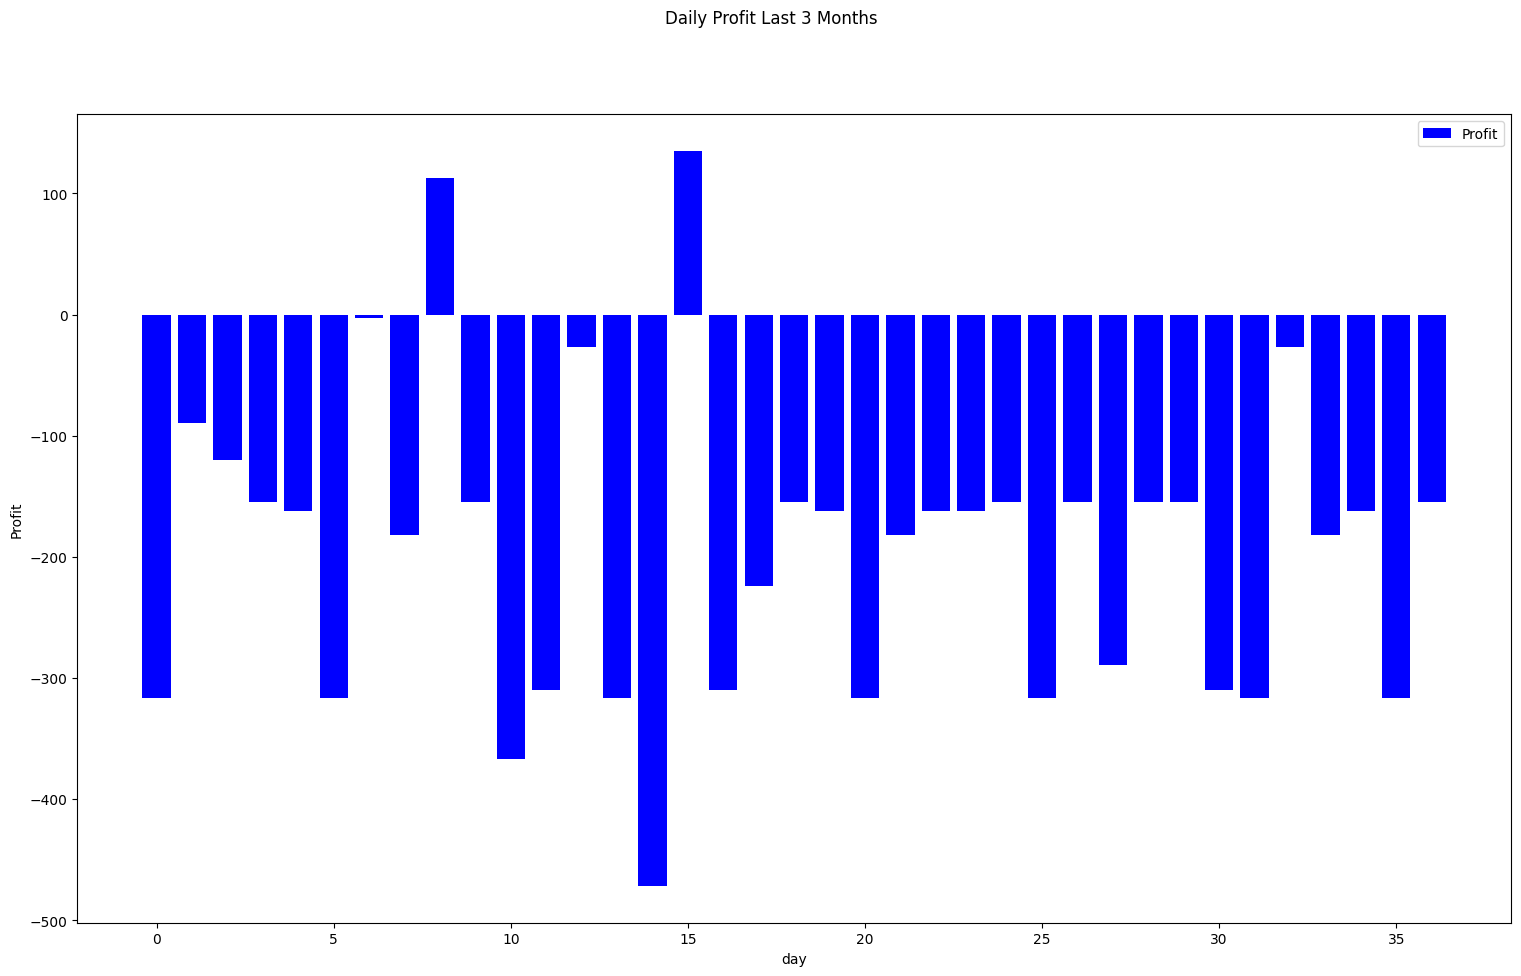

In [26]:
from matplotlib.dates import relativedelta

three_months = max_date_1hr - relativedelta(months=3)

fig, ax = plt.subplots()
width = 0.5
profit_df_daily_last_3_months = profit_df_daily.filter(pl.col('entry_time') >= pd.to_datetime(three_months)).to_pandas()
# convert the index to an integer
profit_df_daily_last_3_months['day_number'] = profit_df_daily_last_3_months.entry_time.dt.dayofyear 
# add a column for the 
# profit_df_daily_last_3_months['day_name'] = profit_df_daily_last_3_months.index.strftime('%U')
# # convert the dai_name to an integer
# profit_df_daily_last_3_months['day_name'] = profit_df_daily_last_3_months['day_name'].astype(int)
# reset the index
# profit_df_daily_last_3_months_reset = profit_df_daily_last_3_months.reset_index()

ax.bar(profit_df_daily_last_3_months.index, profit_df_daily_last_3_months['profit'], label='Profit', color='blue') #, width=width

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Daily Profit Last 3 Months')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()

In [27]:
# find the sum of negative and msolutions_negative
negative_sum = len(profit_df_daily.filter(pl.col('profit') < 0))
total_days = len(profit_df_daily)
total_profit = profit_df['profit'].sum()
min_daily = profit_df_daily['profit'].min()
print(negative_sum, total_days, negative_sum/total_days, '${:,.2f}'.format(total_profit), min_daily)

# 4 sma/smoothing and no pyramiding 
# 131 353 0.37110481586402266 $115,757.52 -2838.0000000003347

# 4 sma/smoothing and 4 pyramiding
# 153 353 0.43342776203966005 $403,211.52 -3538.097248103745

1292 1452 0.8898071625344353 $-408,105.53 -1731.7555732072337


## Summation and Plotting

In [28]:
# use the entry time and resample to each day and find the sum of the profit
profit_df_weekly = profit_df.group_by_dynamic('entry_time', every='1w').agg(
    pl.col('profit').sum().alias('profit')
)
# # fill the null values with 0
# profit_df_weekly.fillna(0, inplace=True)
# find the min, max, and mean of profit and msolutions_profit
min = profit_df_weekly['profit'].min()
max = profit_df_weekly['profit'].max()
mean = profit_df_weekly['profit'].mean()
print('min: ', min, 'max: ', max, 'avg: ', mean,)


min:  -6102.740943222966 max:  655.0367935342765 avg:  -1221.872856738096


In [29]:
# export profit_df to a csv file
# profit_df.to_csv('C:/Users/WilliamFetzner/Documents/Trading/profit_df_new.csv')

In [30]:
# filter profit_df_weekly to just september 
# profit_df_weekly.loc['2023-09']

In [31]:
# use the entry time and resample to each day and find the sum of the profit
profit_df_monthly = profit_df.group_by_dynamic('entry_time', every='1mo').agg(
    pl.col('profit').sum().alias('profit')
)
# # fill the null values with 0
# profit_df_monthly.fillna(0, inplace=True)
# find the min, max, and mean of profit
min = profit_df_monthly['profit'].min()
max = profit_df_monthly['profit'].max()
mean = profit_df_monthly['profit'].mean()
print('min: ', min, 'max: ', max, 'mean: ', mean)
# find where the profit is equal to the min
profit_df_monthly.filter(pl.col('profit') == min)

min:  -18161.20537783862 max:  -1105.166774399119 mean:  -5232.1222326990255


entry_time,profit
datetime[μs],f64
2020-03-01 00:00:00,-18161.205378


In [32]:
profit_df_monthly

entry_time,profit
datetime[μs],f64
2018-03-01 00:00:00,-4744.922606
2018-04-01 00:00:00,-6872.818983
2018-05-01 00:00:00,-10487.767431
2018-06-01 00:00:00,-6983.271302
2018-07-01 00:00:00,-5431.552522
…,…
2024-04-01 00:00:00,-3872.719038
2024-05-01 00:00:00,-2070.874602
2024-06-01 00:00:00,-2566.000259


In [33]:
# find the end balance for nova profit and msolutions profit by summing the profits and adding to the starting balance
end_balance = balance + profit_df['profit'].sum()
# convert to dollars
end_balance_dollars = '${:,.2f}'.format(end_balance)
print(f'End Balance: {end_balance_dollars}')
# 4 sma/smoothing and no pyramiding
# Nova End Balance: $315,757.52
# MSolutions End Balance: $294,088.52

# 4 sma/smoothing and 4 pyramiding
# Nova End Balance: $603,211.52
# MSolutions End Balance: $557,752.52

End Balance: $-208,105.53


In [34]:
total_take_home = ((end_balance-balance)*.8 ) + ((end_balance-balance)*.75)
print(total_take_home)

-632563.5779333126


In [35]:
# calculate the win rate for nova
win_rate = profit_df.filter(profit_df['profit'] > 0).shape[0] / profit_df.shape[0]
# find the number of times that initial TP was hit and then the 
print('Nova Win Rate: ', win_rate)
# Nova Win Rate:  0.4040728831725616 MSolutions Win Rate:  0.4040728831725616 - 4 sma/smoothing and no pyramiding
# Nova Win Rate:  0.37916310845431256 MSolutions Win Rate:  0.37916310845431256 - 3 sma/smoothing and no pyramiding
# Nova Win Rate:  0.3762057877813505 MSolutions Win Rate:  0.3740621650589496 - 4 sma/smoothing and 4 pyramiding

Nova Win Rate:  0.2063381910710155


In [36]:
# find the min for profit and msolutions_profit
min = profit_df['profit'].min()
print(f'Min: ${min}')
# find the max for profit and msolutions_profit
max = profit_df['profit'].max()
print(f'Max: ${max}')

Min: $-162.0259703171706
Max: $134.97402968285445


In [37]:
# average RR ratio
# find the average RR ratio for profit and msolutions_profit
# find the average profit for trades that were positive for profit
avg_profit = profit_df.filter(profit_df['profit'] > 0)['profit'].mean()
# find the average profit for trades that were negative for profit
avg_loss = profit_df.filter(profit_df['profit'] < 0)['profit'].mean()
avg_profit/abs(avg_loss)

0.838542628661308

In [38]:
# create a new column for cum_sum of profit and msolutions_profit
profit_df = profit_df.with_columns([pl.col('profit').cum_sum().alias('profit_cum_sum')])

In [39]:
# find the min of cum_sum
min_cum_sum_min = profit_df['profit_cum_sum'].min()
min_cum_sum_min

-408105.5341505536

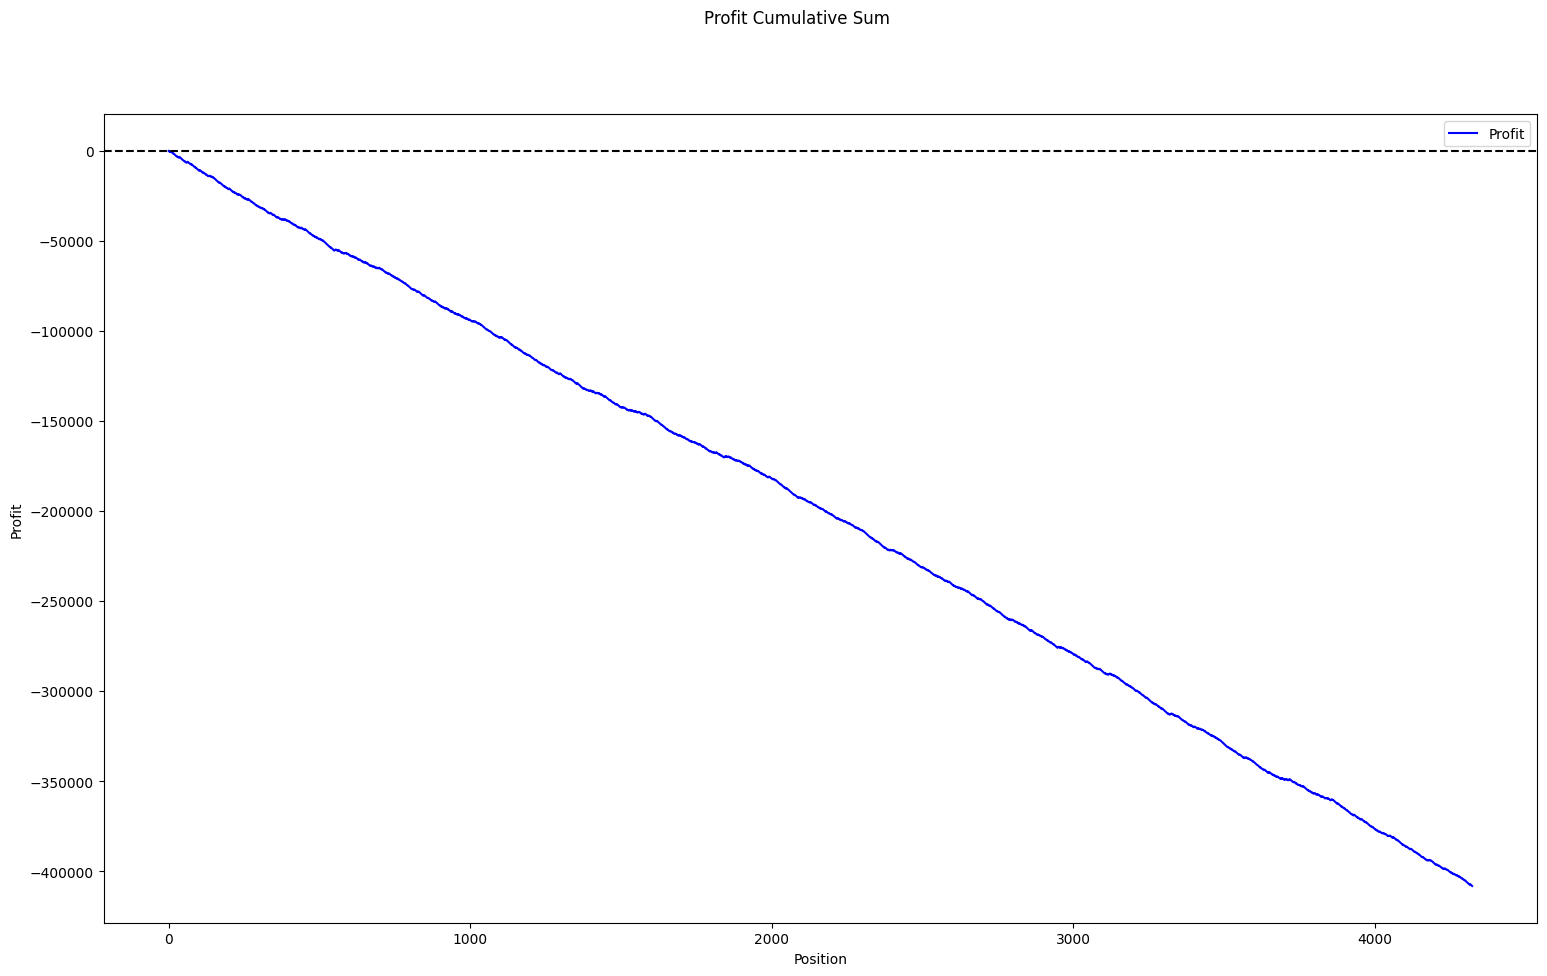

In [40]:
# graph profit_dollars and msolutions_profit_dollars over cum_position_count
fig, ax = plt.subplots()
ax.plot(profit_df['profit_cum_sum'], label='Profit', color='blue')
# add in a line for 0 
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel('Position')
ax.set_ylabel('Profit')
fig.suptitle('Profit Cumulative Sum')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)
# Add legend
ax.legend()
# Show the plot
plt.show()


In [41]:
profit_df_monthly

entry_time,profit
datetime[μs],f64
2018-03-01 00:00:00,-4744.922606
2018-04-01 00:00:00,-6872.818983
2018-05-01 00:00:00,-10487.767431
2018-06-01 00:00:00,-6983.271302
2018-07-01 00:00:00,-5431.552522
…,…
2024-04-01 00:00:00,-3872.719038
2024-05-01 00:00:00,-2070.874602
2024-06-01 00:00:00,-2566.000259


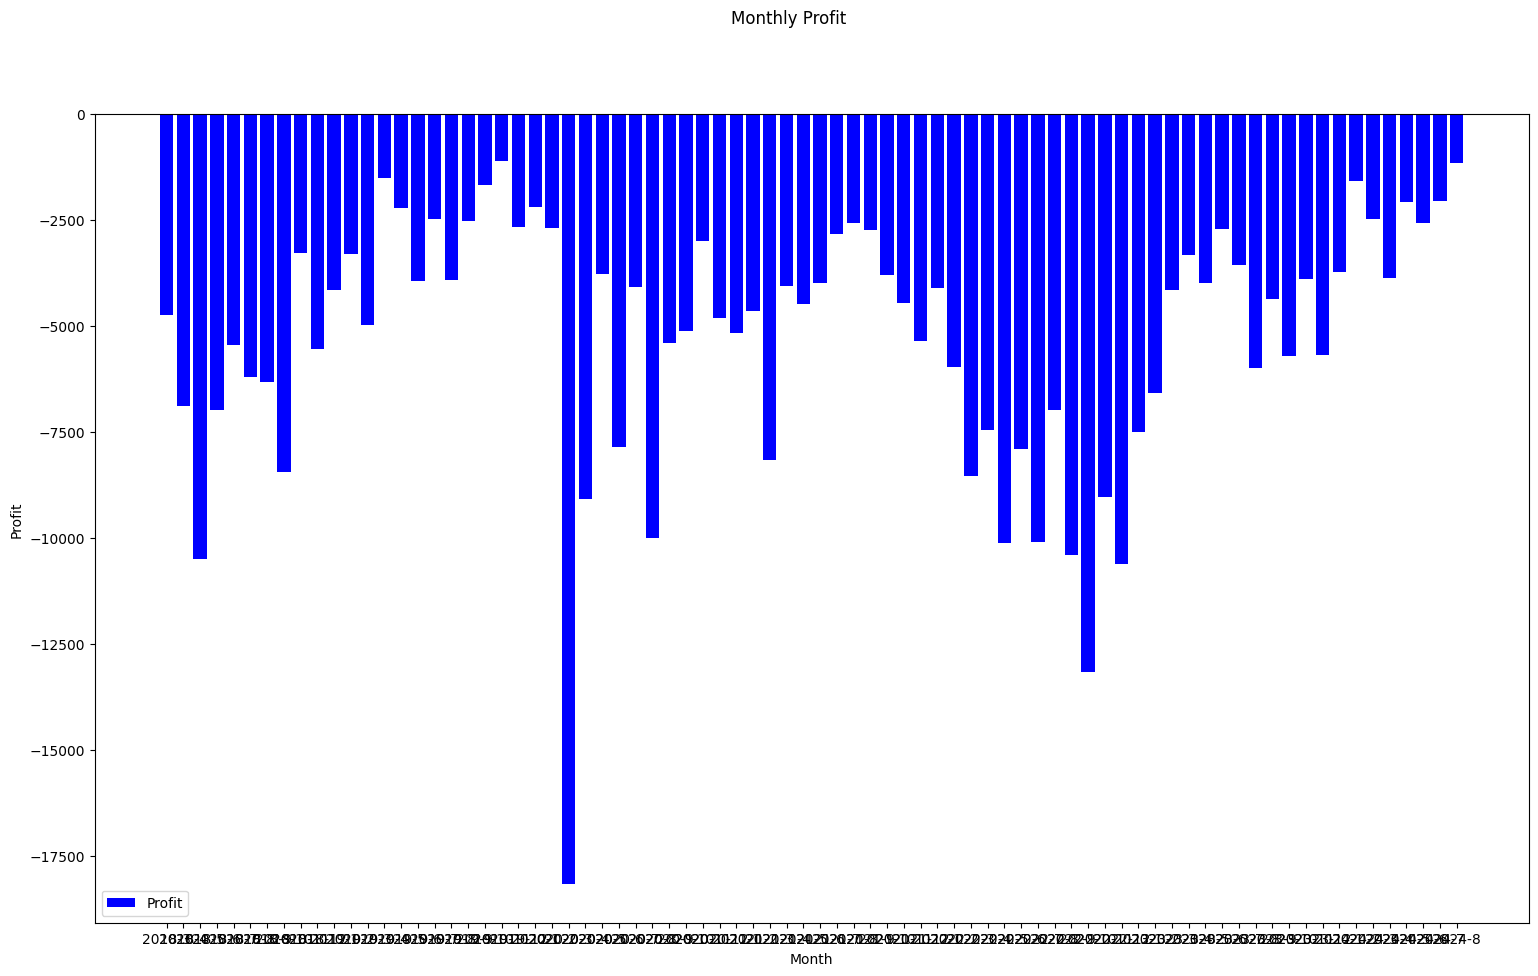

In [42]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_monthly = profit_df_monthly.with_columns(
    pl.col('entry_time').dt.month().cast(pl.Utf8).alias('month'),
    pl.col('entry_time').dt.year().cast(pl.Utf8).alias('year'),
    ).with_columns(
        pl.concat_str([pl.col('year'), pl.lit('-'), pl.col('month')]).alias('year_month')
    )

# concat the year and month like '2023-01'
# profit_df_monthly['year_month'] = profit_df_monthly['year'].astype(str) + '-' + profit_df_monthly['month'].astype(str)
# profit_df_monthly

# Nova Profit
ax.bar(range(0, len(profit_df_monthly)), profit_df_monthly['profit'], label='Profit', color='blue') #, width=width/2

# set the x axis labels to be from the column 'year_month'
ax.set_xticks(range(0, len(profit_df_monthly)))
ax.set_xticklabels(profit_df_monthly['year_month'])

ax.set_xlabel('Month')
ax.set_ylabel('Profit')
fig.suptitle('Monthly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


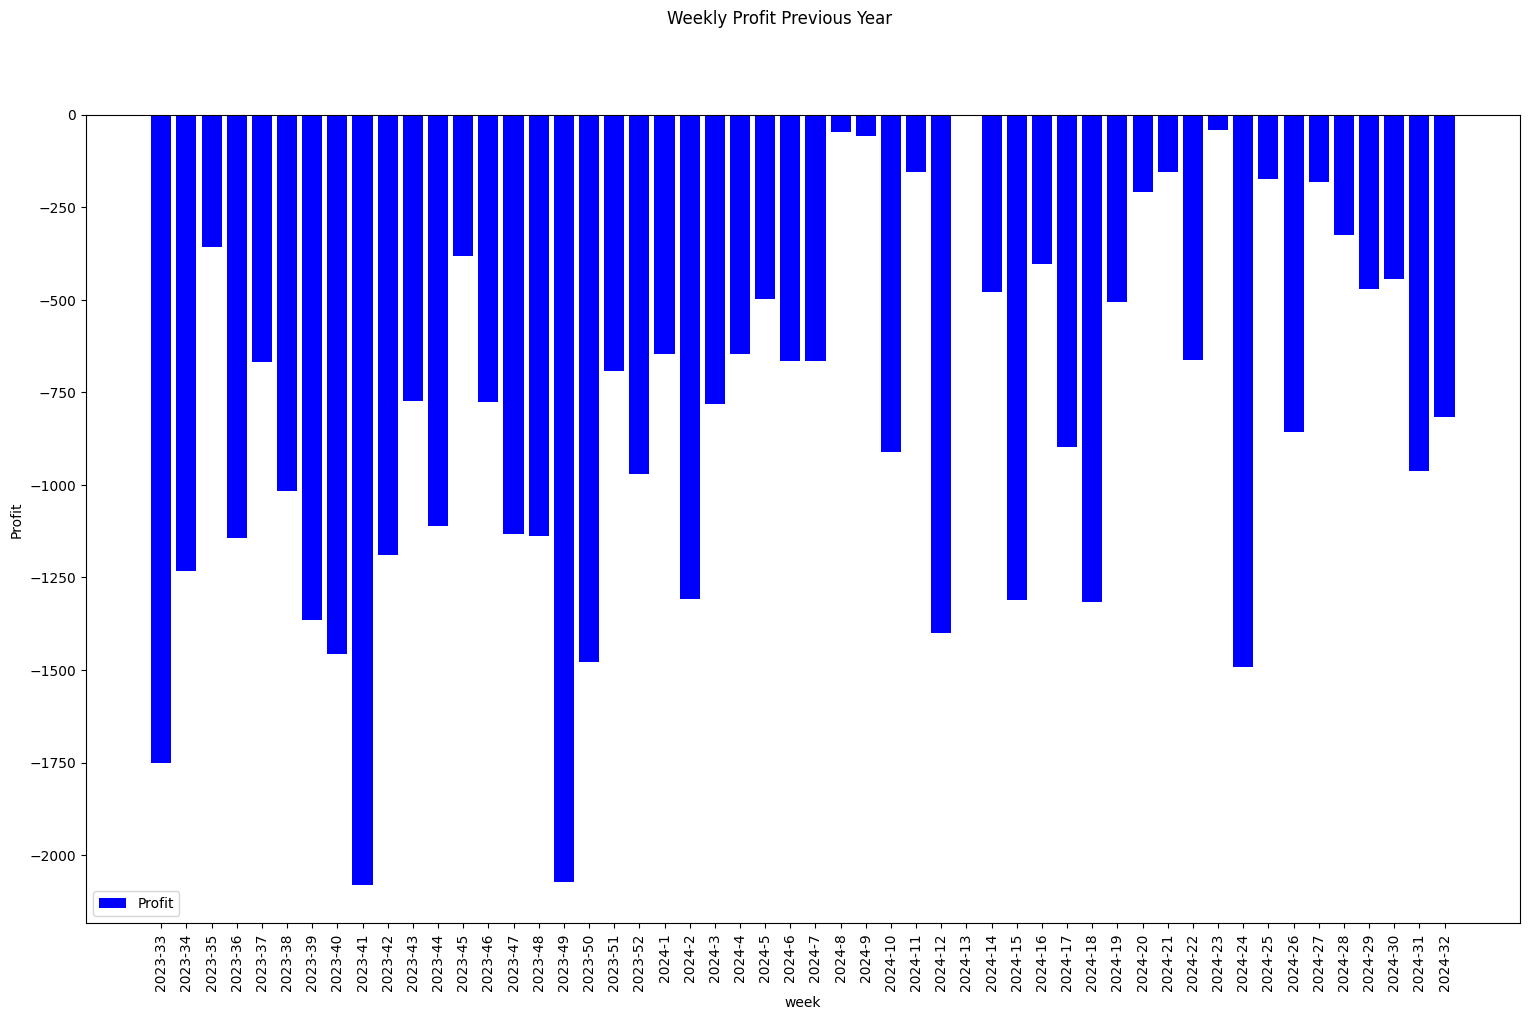

In [43]:
fig, ax = plt.subplots()
width = 0.5

profit_df_weekly_fil = profit_df_weekly.with_columns(
    pl.col('entry_time').dt.week().cast(pl.Utf8).alias('week'),
    pl.col('entry_time').dt.year().cast(pl.Utf8).alias('year'),
).with_columns(
        pl.concat_str([pl.col('year'), pl.lit('-'), pl.col('week')]).alias('year_week')
    ).filter(pl.col('entry_time') >= (max_date_1hr - timedelta(days=365)))


# Profit
ax.bar(range(len(profit_df_weekly_fil)), profit_df_weekly_fil['profit'], label='Profit', color='blue')


# set the x axis labels to be from the column 'year_month'
ax.set_xticks(range(len(profit_df_weekly_fil)))
ax.set_xticklabels(profit_df_weekly_fil['year_week'])
# rotate the x axis labels vertically
plt.xticks(rotation=90)

ax.set_xlabel('week')
ax.set_ylabel('Profit')
fig.suptitle('Weekly Profit Previous Year')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [44]:
# what is the median of profit
median = profit_df_weekly['profit'].median()
print('Median: ', median)
# what is the average
mean = profit_df_weekly['profit'].mean()
print('Mean: ', mean)

Median:  -1125.218715033478
Mean:  -1221.872856738096


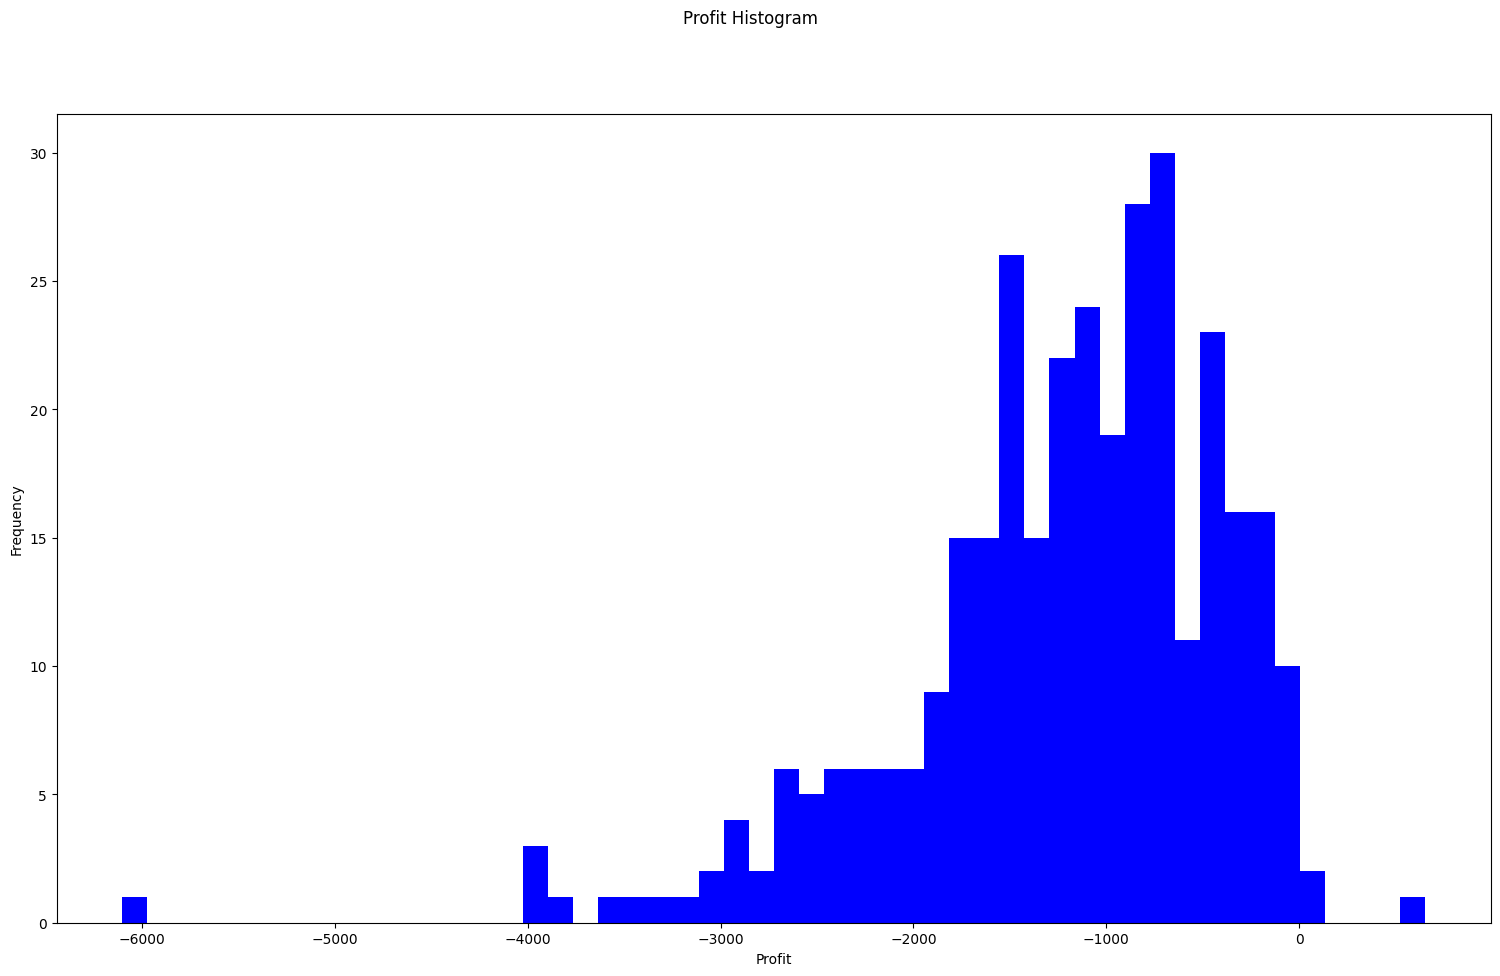

In [45]:
# create a histogram of the profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_weekly['profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


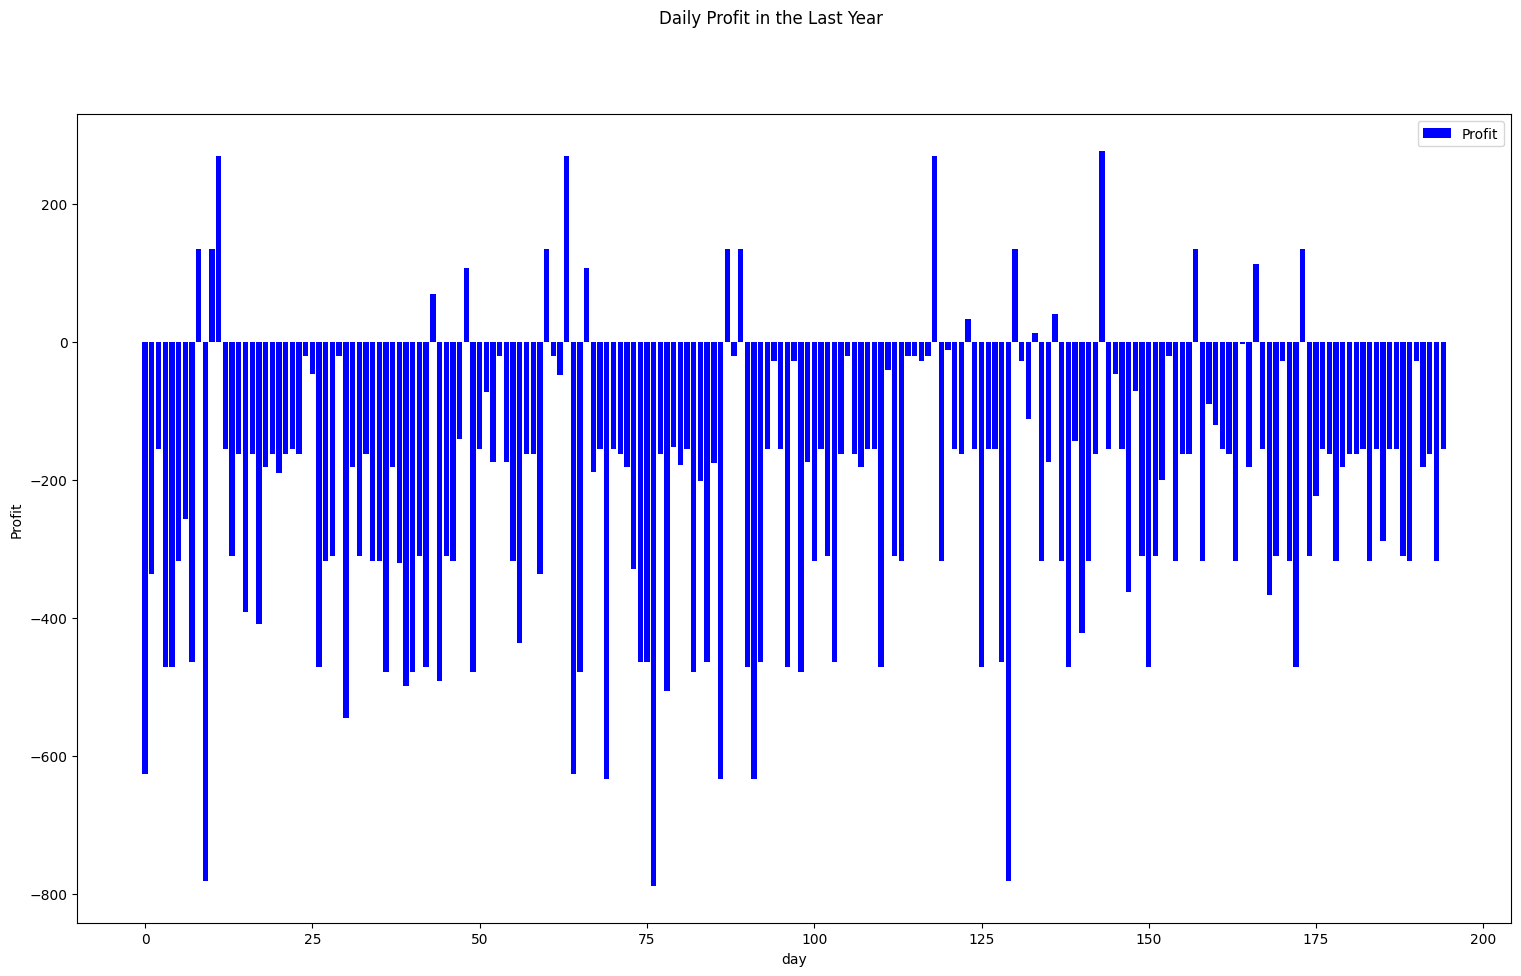

In [46]:
fig, ax = plt.subplots()
width = 0.5

profit_df_daily_fil = profit_df_daily.with_columns(
    pl.col('entry_time').dt.day().cast(pl.Int64).alias('day_number'),
).filter(pl.col('entry_time') >= (max_date_1hr - timedelta(days=365)))


# Profit
ax.bar(range(len(profit_df_daily_fil)), profit_df_daily_fil['profit'], label='Profit', color='blue')

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Daily Profit in the Last Year')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


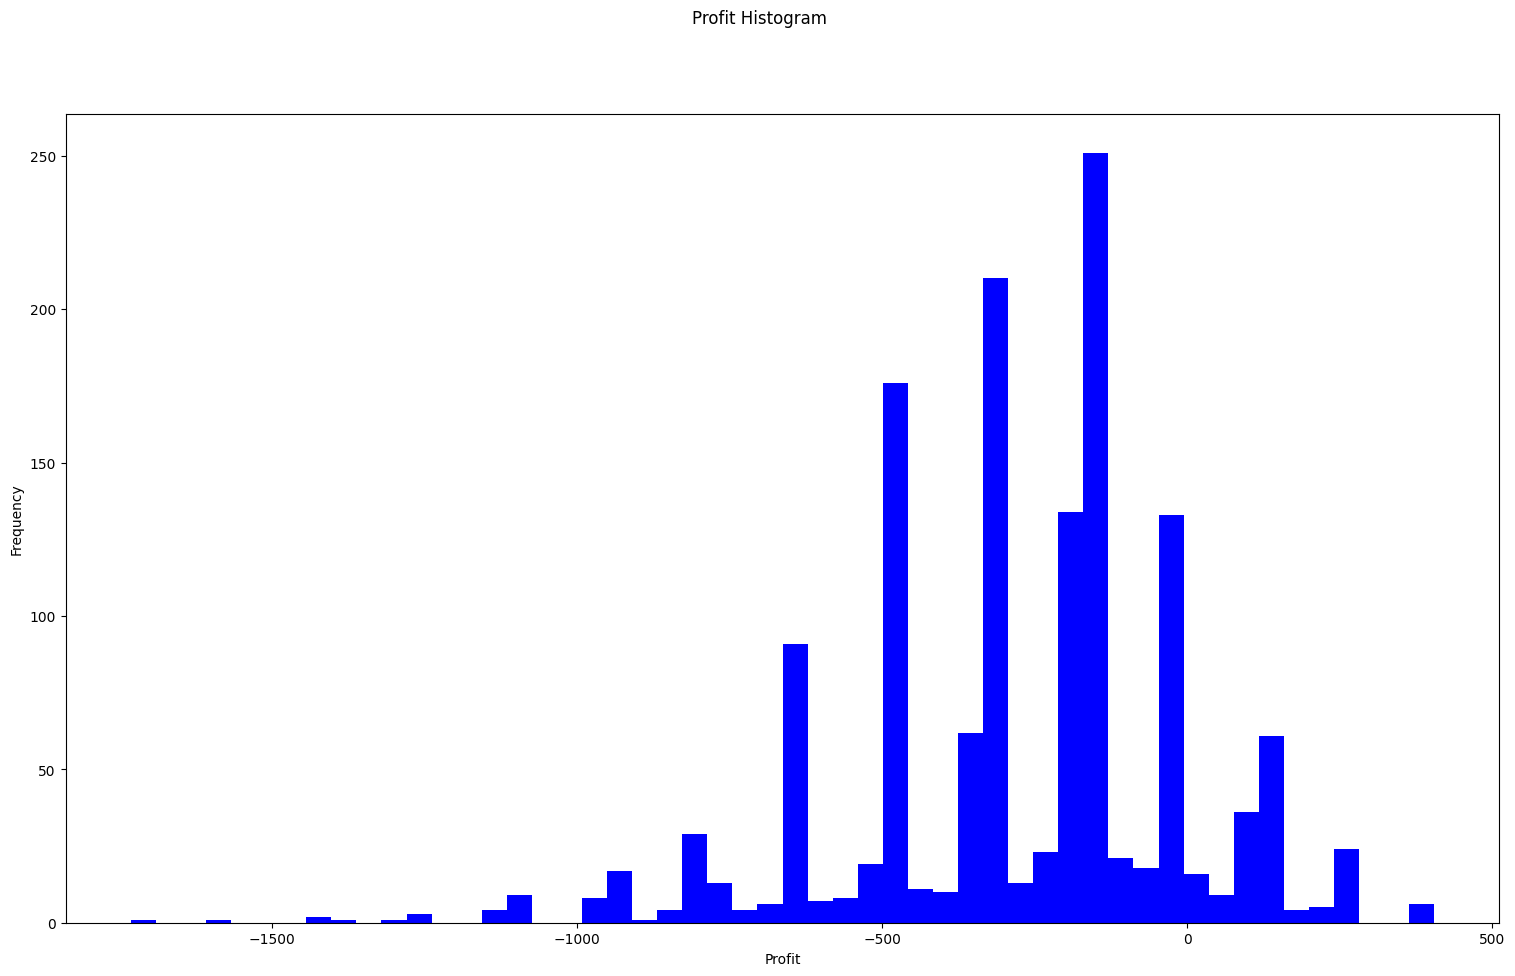

In [47]:
# create a histogram of the profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_daily['profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [48]:
# show the bins and counts from histogram in a table
profit_hist = np.histogram(profit_df_daily['profit'], bins=52)
# put this into a pandas dataframe
profit_hist_df = pd.DataFrame({'bin': profit_hist[1][:-1], 'count': profit_hist[0]})
profit_hist_df


,bin,count
0,-1731.755573,1
1,-1690.665618,0
2,-1649.575663,0
3,-1608.485708,1
4,-1567.395753,0
5,-1526.305798,0
6,-1485.215843,0
7,-1444.125888,2
8,-1403.035933,1
9,-1361.945978,0


## Hour distribution

In [49]:
# find the win rate grouped by entry_hour and the number of trades taken for each hour
win_rate_by_hour = (
    profit_df.with_columns(pl.col("entry_time").dt.hour().alias("entry_hour"))
    .group_by("entry_hour")
    .agg([
        pl.col("profit").filter(pl.col("profit") > 0).count().alias("win_count"),
        pl.col("profit").count().alias("total_trades"),
        pl.col("entry_time").count().alias("entry_time_count")
    ])
    .with_columns((pl.col("win_count") / pl.col("total_trades")).alias("win_rate"))
).sort("entry_hour")

win_rate_by_hour

entry_hour,win_count,total_trades,entry_time_count,win_rate
i8,u32,u32,u32,f64
0,2,7,7,0.285714
1,8,24,24,0.333333
2,10,42,42,0.238095
3,28,139,139,0.201439
4,34,129,129,0.263566
…,…,…,…,…
19,24,173,173,0.138728
20,30,163,163,0.184049
21,15,136,136,0.110294


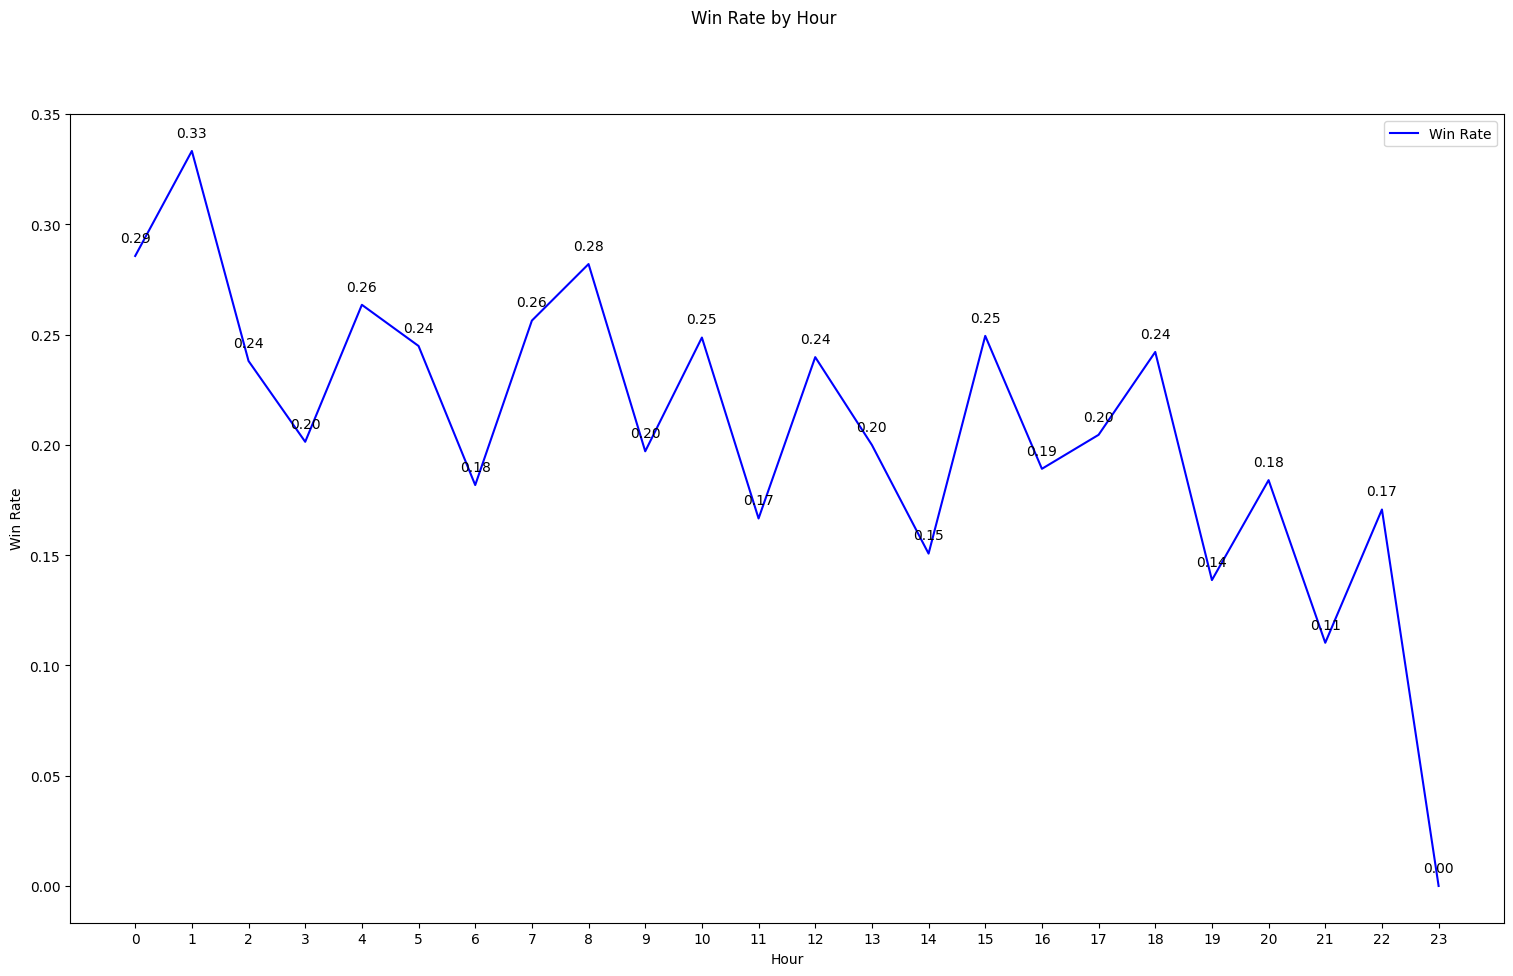

In [50]:
# create a line graph of the win rate by hour
fig, ax = plt.subplots()
win_rate_by_hour_pd = win_rate_by_hour.to_pandas()
ax.plot(win_rate_by_hour_pd.index, win_rate_by_hour_pd['win_rate'], label='Win Rate', color='blue')
# show the values for x and y next to the points
for i, txt in enumerate(win_rate_by_hour_pd['win_rate']):
    ax.annotate(f'{txt:.2f}', (win_rate_by_hour_pd.index[i], win_rate_by_hour_pd['win_rate'][i]), textcoords="offset points", xytext=(0,10), ha='center')
# show all of the ticks on the x axis
ax.set_xticks(win_rate_by_hour_pd.index)
ax.set_xlabel('Hour')
ax.set_ylabel('Win Rate')
fig.suptitle('Win Rate by Hour')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [51]:
# filter out any rows that have entry_hour as 
low_win_perc_hrs = [0,1,2,3,4,23] #20, 21,
low_win_perc_removed = profit_df.with_columns(pl.col("entry_time").dt.hour().alias("entry_hour"))\
    .filter(~pl.col('entry_hour').is_in(low_win_perc_hrs))
# find the sum of profit for low_win_perc_removed
print(low_win_perc_removed['profit'].sum(), profit_df['profit'].sum())



-375541.59303600754 -408105.53415052424


In [52]:
# export the profit_df to a csv
# profit_df.write_csv('profit_df.csv')

## Investigation of losing trades

I was trying to figure out if I should exit earlier on the renko chart or make it more difficult to enter based on the losing trades

In [53]:
# # add a new column to profit_df that is the number of rows in renko_full_data for each position
# profit_df['num_rows'] = renko_full_data.groupby('cum_position_count').size()
# # filter profit_df to just the losing positions
# losing_positions = profit_df[profit_df['profit'] < 0]
# min_loss = losing_positions.msolutions_profit.min()

In [54]:
# # create a list of all the losing position cum_position_count
# losing_positions_list = losing_positions.index.tolist()
# # find the average number of rows for each position in renko_full_data that are in the losing_positions_list
# avg_rows = renko_full_data.loc[renko_full_data['cum_position_count'].isin(losing_positions_list)].shape[0] / len(losing_positions_list)
# avg_rows

In [55]:
# # find the standard deviation of num_rows in losing_positions
# std_rows = losing_positions.num_rows.std()
# max_losing_rows = losing_positions.num_rows.max()
# min_losing_rows = losing_positions.num_rows.min()
# # find the number of rows that occur the most
# mode_losing_rows = losing_positions.num_rows.mode()
# print('std_rows: ', std_rows, 'max_losing_rows: ', max_losing_rows, 'min_losing_rows: ', min_losing_rows, 
#       'avg_rows: ', avg_rows, 'mode_losing_rows: ', mode_losing_rows)



In [56]:
# #create a histogram of the number of rows for the losing positions
# fig, ax = plt.subplots()
# ax.hist(losing_positions['num_rows'], bins=13, color='blue')
# ax.set_xlabel('Number of Rows')
# ax.set_ylabel('Frequency')
# fig.suptitle('Number of Rows for Losing Positions')
# fig.set_size_inches(18.5, 10.5)
# plt.show()

In [57]:
# # what was the cum_position_count for the position with the max_losing_rows
# max_losing_rows_cum_position_count = losing_positions.loc[losing_positions['num_rows'] == max_losing_rows].index[0]
# # filter renko_full_data to just the rows with the min_losing_rows_cum_position_count
# renko_full_data.loc[renko_full_data['cum_position_count'] == max_losing_rows_cum_position_count]

In [58]:
# # filter to where the date and time is between 2024-03-07 16:36:00 and 2024.03.08 12:30:00
# renko_full_data_259 = renko_full_data.loc[renko_full_data['cum_position_count'] == 582]
# # impulse_graph(renko_full_data_259, 'md', 'sb')
# # plot the renko chart
# fig, ax = plt.subplots()
# mplfinance.plot(renko_full_data_259, type='candle', ax=ax, volume=False, show_nontrading=False)
# # drop datetime
# renko_full_data_259.drop(columns=['datetime'], inplace=True)
# renko_full_data_259_reset = renko_full_data_259.reset_index()
# # add the sma and smoothing_sma to the chart
# ax.plot(renko_full_data_259_reset.index, renko_full_data_259['sma'], label='SMA', color='blue')
# ax.plot(renko_full_data_259_reset.index, renko_full_data_259['smoothing_sma'], label='SmoothingSMA', color='orange')
# # add a column to renko_full_data_259_reset that copies the close price when sma_crossover is 1 or -1
# renko_full_data_259_reset['sma_crossover_price_buy'] = np.where(renko_full_data_259['sma_crossover'] == 1, renko_full_data_259['close'], np.nan)
# renko_full_data_259_reset['sma_crossover_price_sell'] = np.where(renko_full_data_259['sma_crossover'] == -1, renko_full_data_259['close'], np.nan)
# # add a dot to the chart with the sma_crossover is 1 or -1 and color it green or red
# ax.scatter(renko_full_data_259_reset.index, renko_full_data_259_reset['sma_crossover_price_buy'], color='green', marker='o', label='Buy', zorder=5)
# ax.scatter(renko_full_data_259_reset.index, renko_full_data_259_reset['sma_crossover_price_sell'], color='red', marker='o', label='Sell', zorder=5)
# ax.set_xlabel('Time')
# ax.set_ylabel('Price')
# # find the date of the first and last index
# first_date = renko_full_data_259_reset['datetime'].iloc[0]
# last_date = renko_full_data_259_reset['datetime'].iloc[-1]
# fig.suptitle(f'EURUSD {first_date.date()} to {last_date.date()} Renko chart')
# # increase the size of the chart
# fig.set_size_inches(18.5, 10.5)

# plt.show()